### Model Portfolio Max Sharpe Ratio

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from dotenv import load_dotenv
import os

# -----------------------------
# Setup & MT5 initialization
# -----------------------------
load_dotenv()
login = int(os.getenv("ACG_MT5_LOGIN"))
password = os.getenv("ACG_MT5_PASSWORD")
server = os.getenv("ACG_MT5_SERVER")

if not mt5.initialize(login=login, password=password, server=server):
    print("initialize() failed, error code =", mt5.last_error())
    quit()

# -----------------------------
# Config
# -----------------------------
risk_free_rate = 0.0  # annual risk-free rate

# FX pairs needed to convert index returns to USD
fx_map = {
    "GER30.pro": "EURUSD.pro",
    "JPN225.pro": "USDJPY.pro",   # flip sign
    "HK50.pro": "USDHKD.pro",     # flip sign
    "UK100.pro": "GBPUSD.pro",
    "EUSTX50.pro": "EURUSD.pro"
}

# -----------------------------
# Helpers
# -----------------------------
def fetch_mt5_data(symbol, days=60):
    utc_to = pd.Timestamp.now()
    utc_from = utc_to - pd.Timedelta(days=days)

    rates = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_D1, utc_from, utc_to)
    if rates is None:
        raise ValueError(f"Failed to fetch data for {symbol}")

    df = pd.DataFrame(rates)
    df["time"] = pd.to_datetime(df["time"], unit="s")
    df.set_index("time", inplace=True)
    return df

def calculate_log_returns(prices: pd.Series) -> pd.Series:
    return np.log(prices / prices.shift(1)).dropna()

# -----------------------------
# Load expected returns
# -----------------------------
# ai_factor_signal_acg.csv:  asset \t factor_signal
expected_returns_df = pd.read_csv("ai_factor_signal_acg.csv", sep="\t", header=None)
expected_returns_df.columns = ["asset", "factor_signal"]

# -----------------------------
# Z-score the factor signals
# -----------------------------
mean_signal = expected_returns_df["factor_signal"].mean()
std_signal = expected_returns_df["factor_signal"].std()

expected_returns_df["zscore_signal"] = (expected_returns_df["factor_signal"] - mean_signal) / std_signal

# Convert to dict
expected_returns_dict = dict(zip(expected_returns_df["asset"], expected_returns_df["zscore_signal"]))

symbols = list(expected_returns_dict.keys())

# -----------------------------
# Fetch price data for assets
# -----------------------------
data = {symbol: fetch_mt5_data(symbol) for symbol in symbols}

# -----------------------------
# Fetch FX data and compute FX log returns
# -----------------------------
fx_symbols = set(fx_map[s] for s in symbols if s in fx_map)
fx_data = {fx: fetch_mt5_data(fx) for fx in fx_symbols}

fx_returns = {}
for fx, df_fx in fx_data.items():
    lr = calculate_log_returns(df_fx["close"])

    # If pair is quoted as USDXXX (e.g., USDJPY, USDHKD), flip sign to get XXXUSD log return
    if fx.startswith("USD"):
        lr = -lr  # log(1/x) = -log(x)

    fx_returns[fx] = lr

# -----------------------------
# Compute USD-adjusted log returns for all assets
# -----------------------------
asset_returns = {}

for symbol in symbols:
    idx_lr = calculate_log_returns(data[symbol]["close"])

    if symbol in fx_map:
        fx_symbol = fx_map[symbol]
        fx_lr = fx_returns[fx_symbol]

        # Align index and FX by date
        combined = pd.concat([idx_lr, fx_lr], axis=1, join="inner")
        combined.columns = ["idx", "fx"]

        # USD-adjusted return: r_usd = r_index_local + r_fx
        asset_returns[symbol] = combined["idx"] + combined["fx"]
    else:
        # Already in USD terms
        asset_returns[symbol] = idx_lr

# -----------------------------
# Build aligned returns matrix
# -----------------------------
returns = pd.DataFrame(asset_returns).dropna(how="any")

# -----------------------------
# Covariance matrix (daily, log returns)
# -----------------------------
cov_matrix = returns.cov()

# Expected daily returns vector (assumed to be in USD terms already)
expected_returns = np.array([expected_returns_dict[symbol] for symbol in symbols])
expected_returns = expected_returns * returns.std().values  # scale by asset volatilities

# -----------------------------
# Max Sharpe optimization
# -----------------------------
def max_sharpe_ratio(expected_returns, cov_matrix, risk_free_rate=0.0):
    num_assets = len(expected_returns)

    def neg_sharpe(weights):
        port_ret = np.dot(weights, expected_returns)
        port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(port_ret - risk_free_rate) / port_vol

    # Dollar-neutral: sum(weights) = 0
    constraints = [{"type": "eq", "fun": lambda w: np.sum(w)}]

    # Allow long/short
    bounds = [(-1, 1)] * num_assets

    # Start with zero‑sum initial guess
    init_guess = np.ones(num_assets)
    init_guess[: num_assets // 2] = 1
    init_guess[num_assets // 2 :] = -1
    init_guess = init_guess / np.sum(np.abs(init_guess))

    result = minimize(neg_sharpe, init_guess, bounds=bounds, constraints=constraints)

    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    weights = result.x
    daily_ret = np.dot(weights, expected_returns)
    daily_vol = np.sqrt(weights.T @ cov_matrix @ weights)

    return weights, daily_ret, daily_vol

# -----------------------------
# Run optimization
# -----------------------------
weights, daily_port_return, daily_port_vol = max_sharpe_ratio(
    expected_returns, cov_matrix, risk_free_rate=risk_free_rate
)

# -----------------------------
# Export optimal weights
# -----------------------------
weights_df = pd.DataFrame({
    "Symbol": symbols,
    "Weight": weights
})
weights_df.to_csv("acg_optimal_portfolio_weights.csv", header=False, index=False)
print("\nWeights exported to acg_optimal_portfolio_weights.csv")

# -----------------------------
# Annualized statistics (using daily log returns)
# -----------------------------
annual_port_return = (1 + daily_port_return)**252 - 1
annual_port_vol = daily_port_vol * np.sqrt(252)
annual_sharpe = (annual_port_return - risk_free_rate) / annual_port_vol

# -----------------------------
# Output
# -----------------------------
print("\nOptimal Portfolio Weights:")
for symbol, weight in zip(symbols, weights):
    print(f"{symbol}: {weight:.4f}")

print("\n--- Portfolio Statistics ---")
print(f"Daily Portfolio Return: {daily_port_return:.4%}")
print(f"Annualized Portfolio Return: {annual_port_return:.4%}")
print(f"Daily Portfolio Volatility: {daily_port_vol:.4%}")
print(f"Annualized Portfolio Volatility: {annual_port_vol:.4%}")
print(f"Annualized Sharpe Ratio: {annual_sharpe:.2f}")

# -----------------------------
# Shutdown MT5
# -----------------------------
mt5.shutdown()


Weights exported to acg_optimal_portfolio_weights.csv

Optimal Portfolio Weights:
AUDUSD.pro: -0.6350
EURUSD.pro: -0.1879
GBPUSD.pro: 0.9669
NZDUSD.pro: 0.1590
USDJPY.pro: -0.3911
USDCHF.pro: 0.2325
USDCAD.pro: -0.2073
XAGUSD.pro: 0.1146
XAUUSD.pro: 0.0277
USOIL.pro: -0.5437
UKOIL.pro: 0.3484
US500.pro: 0.8452
US30.pro: -0.2333
NAS100.pro: -0.1324
GER30.pro: 0.1102
JPN225.pro: -0.2055
HK50.pro: 0.1587
UK100.pro: -0.0850
EUSTX50.pro: -0.3420

--- Portfolio Statistics ---
Daily Portfolio Return: 1.6462%
Annualized Portfolio Return: 6023.1442%
Daily Portfolio Volatility: 0.4943%
Annualized Portfolio Volatility: 7.8467%
Annualized Sharpe Ratio: 767.60


True

In [2]:
returns

,AUDUSD.pro,EURUSD.pro,GBPUSD.pro,NZDUSD.pro,USDJPY.pro,USDCHF.pro,USDCAD.pro,XAGUSD.pro,XAUUSD.pro,USOIL.pro,UKOIL.pro,US500.pro,US30.pro,NAS100.pro,GER30.pro,JPN225.pro,HK50.pro,UK100.pro,EUSTX50.pro
time,,,,,,,,,,,,,,,,,,,
2025-11-17,-0.006677,-0.002645,-0.001481,-0.004023,0.004649,0.002465,0.002336,-0.007922,-0.009868,-0.002556,-0.005208,-0.009776,-0.011651,-0.009385,-0.019311,-0.017380,-0.013668,-0.007513,-0.015485
2025-11-18,0.002200,-0.001114,-0.000677,0.000018,0.001931,0.004512,-0.004614,0.009680,0.005483,0.014960,0.011947,-0.010474,-0.012842,-0.014967,-0.011793,-0.025305,-0.006715,-0.007962,-0.013234
2025-11-19,-0.004281,-0.003573,-0.006778,-0.009628,0.010483,0.007500,0.004173,0.012944,0.002574,-0.019201,-0.017904,0.010451,0.002523,0.017283,-0.001597,0.013554,-0.005765,-0.007248,0.000131
2025-11-20,-0.006084,-0.000850,0.001140,-0.003630,0.001812,0.000261,0.003482,-0.013754,0.000162,-0.011319,-0.008836,-0.021447,-0.008563,-0.036188,-0.014642,-0.031851,-0.015734,-0.012119,-0.015124
2025-11-21,0.002512,-0.000998,0.002331,0.005110,-0.007113,0.002999,0.000128,-0.012384,-0.002996,-0.013462,-0.010257,0.012003,0.011667,0.011299,0.011708,0.013876,0.003308,0.017457,0.009060
2025-11-24,0.001207,0.000486,0.000244,-0.000071,0.003595,-0.000173,0.000390,0.027229,0.017439,0.015295,0.012548,0.014399,0.003596,0.025248,0.000773,0.013274,0.014521,-0.003422,-0.001973
2025-11-25,0.000866,0.004287,0.004651,0.001656,-0.005304,-0.000656,-0.000511,0.001187,-0.001592,-0.013420,-0.011957,0.008255,0.014231,0.004266,0.018944,-0.002376,0.004811,0.014244,0.016531
2025-11-26,0.007484,0.002253,0.005574,0.013977,0.002368,-0.004244,-0.003994,0.036461,0.008024,0.007620,0.007052,0.007503,0.006758,0.010074,0.009655,0.017407,-0.002257,0.011681,0.012313
2025-11-27,0.002191,-0.000060,-0.000151,0.004849,-0.000991,0.000758,-0.000969,0.000675,-0.001947,0.009490,0.007553,-0.000076,-0.000294,-0.000392,0.001418,-0.000446,0.001122,0.000637,0.000078


### Volatility Forecast EWMA

In [3]:
import pandas as pd
import numpy as np

# --- RAW VOLATILITY (standard deviation) ---
asset_daily_vol = returns.std()

print("\n--- Raw Daily Volatilities (Std Dev) ---")
for symbol, vol in zip(symbols, asset_daily_vol):
    print(f"{symbol}: {vol:.2%}")

# --- EWMA VOLATILITY (RiskMetrics) ---
lambda_ = 0.94  # decay factor

# EWMA variance formula applied per asset
ewma_var = returns.pow(2).ewm(alpha=1 - lambda_).mean()
ewma_vol = np.sqrt(ewma_var)

# Last EWMA volatility value per asset
asset_ewma_vol = ewma_vol.tail(1).T.iloc[:, 0]

print("\n--- EWMA Daily Volatilities (λ = 0.94) ---")
for symbol, vol in zip(symbols, asset_ewma_vol):
    print(f"{symbol}: {vol:.2%}")

# --- COMPARISON TABLE ---
comparison_df = pd.DataFrame({
    "raw_vol": asset_daily_vol,
    "ewma_vol": asset_ewma_vol
})

print("\n--- Raw vs EWMA Volatility Comparison ---")
print(comparison_df.map(lambda x: f"{x:.2%}"))

# --- EXPORT TO CSV ---
comparison_df.to_csv(
    "acg_asset_vol_comparison.csv",
    sep="\t",
    header=True,
    index=True
)


--- Raw Daily Volatilities (Std Dev) ---
AUDUSD.pro: 0.37%
EURUSD.pro: 0.23%
GBPUSD.pro: 0.35%
NZDUSD.pro: 0.44%
USDJPY.pro: 0.47%
USDCHF.pro: 0.34%
USDCAD.pro: 0.30%
XAGUSD.pro: 2.75%
XAUUSD.pro: 1.20%
USOIL.pro: 1.60%
UKOIL.pro: 1.53%
US500.pro: 0.76%
US30.pro: 0.76%
NAS100.pro: 1.15%
GER30.pro: 0.81%
JPN225.pro: 1.33%
HK50.pro: 1.00%
UK100.pro: 0.75%
EUSTX50.pro: 0.77%

--- EWMA Daily Volatilities (λ = 0.94) ---
AUDUSD.pro: 0.35%
EURUSD.pro: 0.22%
GBPUSD.pro: 0.35%
NZDUSD.pro: 0.40%
USDJPY.pro: 0.46%
USDCHF.pro: 0.32%
USDCAD.pro: 0.29%
XAGUSD.pro: 3.44%
XAUUSD.pro: 1.42%
USOIL.pro: 1.69%
UKOIL.pro: 1.64%
US500.pro: 0.62%
US30.pro: 0.72%
NAS100.pro: 0.94%
GER30.pro: 0.67%
JPN225.pro: 1.32%
HK50.pro: 1.06%
UK100.pro: 0.68%
EUSTX50.pro: 0.69%

--- Raw vs EWMA Volatility Comparison ---
            raw_vol ewma_vol
AUDUSD.pro    0.37%    0.35%
EURUSD.pro    0.23%    0.22%
GBPUSD.pro    0.35%    0.35%
NZDUSD.pro    0.44%    0.40%
USDJPY.pro    0.47%    0.46%
USDCHF.pro    0.34%    0.32%


### Correlation Past 60 Trading Days

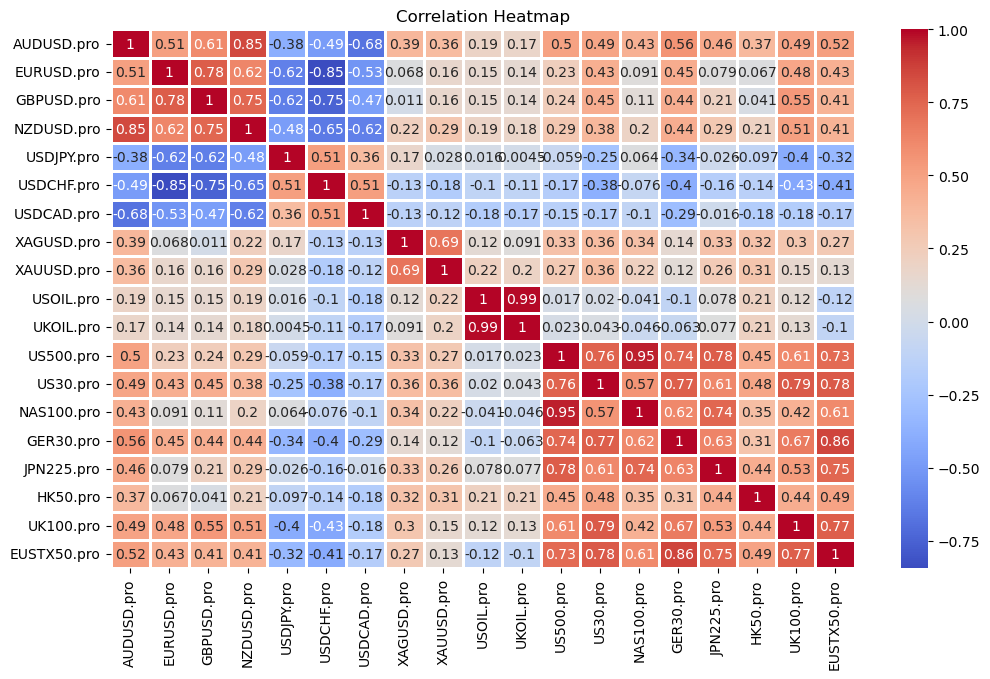

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = returns.corr()

plt.figure(figsize=(12, 7))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.8)
plt.title("Correlation Heatmap")
plt.show()

### Volatility Targeted Weights using EWMA estimates

In [10]:
import pandas as pd
import numpy as np

# --- Load weights from comma-separated file ---
weights_df = pd.read_csv(
    "acg_optimal_portfolio_weights.csv",
    sep=",",
    header=None,
    engine="python",
    encoding="utf-8-sig"
)

weights_df.columns = ["asset", "weight"]

# Align weights to returns.columns order
weights_df = weights_df.set_index("asset").reindex(returns.columns)

# Extract weight vector
weights = weights_df["weight"].values

print("Loaded weights (aligned):")
print(weights)
print("\nAsset order:")
print(list(returns.columns))

# ============================================================
# --- EWMA COVARIANCE MATRIX ---
# ============================================================

lambda_ = 0.94  # RiskMetrics default
rets = returns.values
n = rets.shape[1]

# Start with sample covariance as initial value
ewma_cov = returns.cov().values.copy()

# Iterate through returns to update EWMA covariance
for t in range(1, len(rets)):
    r = rets[t-1].reshape(-1, 1)
    ewma_cov = lambda_ * ewma_cov + (1 - lambda_) * (r @ r.T)

# Portfolio EWMA volatility
ewma_daily_vol = np.sqrt(weights.T @ ewma_cov @ weights)
ewma_annual_vol = ewma_daily_vol * np.sqrt(252)

print("\n--- EWMA VOLATILITY FORECAST ---")
print(f"EWMA Daily Volatility: {ewma_daily_vol:0.2%}")
print(f"EWMA Annual Volatility: {ewma_annual_vol:0.2%}")

# ============================================================
# --- SCALE PORTFOLIO TO TARGET VOLATILITY USING EWMA ---
# ============================================================

target_vol = 0.06  # 5% annual volatility

scale_factor = target_vol / ewma_annual_vol
scaled_weights = weights * scale_factor

# Recompute volatility after scaling
scaled_daily_vol = np.sqrt(scaled_weights.T @ ewma_cov @ scaled_weights)
scaled_annual_vol = scaled_daily_vol * np.sqrt(252)

# Compute scaled returns
scaled_daily_returns = returns @ scaled_weights
scaled_avg_daily_return = scaled_daily_returns.mean()
scaled_annual_return = scaled_avg_daily_return * 252

print(f"\n--- SCALED PORTFOLIO (Target Vol = {target_vol:.0%}) ---")
print(f"Scale Factor: {scale_factor:.4f}")
print(f"Scaled Daily Volatility (EWMA): {scaled_daily_vol:0.2%}")
print(f"Scaled Annual Volatility (EWMA): {scaled_annual_vol:0.2%}")
print(f"Scaled Daily Portfolio Return: {scaled_avg_daily_return:0.2%}")
print(f"Scaled Annual Portfolio Return: {scaled_annual_return:0.2%}")

print("\nScaled Weights:")
for asset, w in zip(returns.columns, scaled_weights):
    print(f"{asset}: {w:.6f}")

# --- EXPORT SCALED WEIGHTS TO CSV ---
scaled_df = pd.DataFrame({
    "asset": returns.columns,
    "scaled_weight": scaled_weights
})

scaled_df.to_csv("acg_scaled_weights.csv", index=False)
print("\nScaled weights exported to acg_scaled_weights.csv")

Loaded weights (aligned):
[-0.63504513 -0.18790064  0.96693904  0.15896454 -0.39113472  0.23246946
 -0.20733097  0.11464861  0.02766708 -0.54374502  0.34841751  0.84522678
 -0.23330621 -0.13238299  0.11022902 -0.2055118   0.15871471 -0.08495542
 -0.34196384]

Asset order:
['AUDUSD.pro', 'EURUSD.pro', 'GBPUSD.pro', 'NZDUSD.pro', 'USDJPY.pro', 'USDCHF.pro', 'USDCAD.pro', 'XAGUSD.pro', 'XAUUSD.pro', 'USOIL.pro', 'UKOIL.pro', 'US500.pro', 'US30.pro', 'NAS100.pro', 'GER30.pro', 'JPN225.pro', 'HK50.pro', 'UK100.pro', 'EUSTX50.pro']

--- EWMA VOLATILITY FORECAST ---
EWMA Daily Volatility: 0.49%
EWMA Annual Volatility: 7.82%

--- SCALED PORTFOLIO (Target Vol = 6%) ---
Scale Factor: 0.7668
Scaled Daily Volatility (EWMA): 0.38%
Scaled Annual Volatility (EWMA): 6.00%
Scaled Daily Portfolio Return: 0.09%
Scaled Annual Portfolio Return: 21.59%

Scaled Weights:
AUDUSD.pro: -0.486974
EURUSD.pro: -0.144089
GBPUSD.pro: 0.741482
NZDUSD.pro: 0.121899
USDJPY.pro: -0.299936
USDCHF.pro: 0.178266
USDCAD.pro:

### Lot Sizing

In [11]:
import pandas as pd
import MetaTrader5 as mt5
import numpy as np

# ============================
# USER CONFIG
# ============================
EQUITY = 103543.79  # set your account equity

# FX-exempt symbols (no price in formula)
FX_EXEMPT = ["USDJPY.pro", "USDCHF.pro", "USDCAD.pro"]

# Global index → FX mapping
INDEX_FX_MAP = {
    "GER30.pro": "EURUSD.pro",
    "JPN225.pro": "USDJPY.pro",
    "HK50.pro": "USDHKD.pro",
    "UK100.pro": "GBPUSD.pro",
    "EUSTX50.pro": "EURUSD.pro"
}

# ============================
# MT5 INITIALIZATION
# ============================
mt5.initialize()

def get_latest_price(symbol):
    tick = mt5.symbol_info_tick(symbol)
    if tick is None:
        return None
    return tick.ask

def fetch_prices(assets):
    return {a: get_latest_price(a) for a in assets}

def fetch_index_fx_rates():
    return {idx: get_latest_price(fx) for idx, fx in INDEX_FX_MAP.items()}

# ============================
# LOAD CSV FILES
# ============================
contract_df = pd.read_csv("acg_contract_size.csv")
weights_df = pd.read_csv("acg_scaled_weights.csv")

# Normalize column names
contract_df.columns = contract_df.columns.str.strip().str.lower()
weights_df.columns = weights_df.columns.str.strip().str.lower()

# Rename scaled_weight → weight
weights_df.rename(columns={"scaled_weight": "weight"}, inplace=True)

# Merge contract sizes + weights
df = contract_df.merge(weights_df, on="asset", how="left")

# ============================
# FETCH PRICES FROM MT5
# ============================
all_assets = df["asset"].tolist()
latest_prices = fetch_prices(all_assets)
index_fx_rates = fetch_index_fx_rates()

df["latest_price"] = df["asset"].map(latest_prices)

# ============================
# LOT SIZE CALCULATION
# ============================
def compute_lot(row):
    asset = row["asset"]
    weight = row["weight"]
    contract_size = row["contract_size"]
    price = row["latest_price"]

    # Missing weight or contract size
    if pd.isna(weight) or pd.isna(contract_size):
        return None

    # Contract size cannot be zero
    if contract_size == 0:
        return None

    # Rule 1: FX-exempt assets
    if asset in FX_EXEMPT:
        return (weight * EQUITY) / contract_size

    # Missing or zero price
    if price is None or price == 0:
        return None

    # Rule 2: Global index → convert to USD
    if asset in INDEX_FX_MAP:
        fx_rate = index_fx_rates.get(asset)
        if fx_rate is None or fx_rate == 0:
            return None
        # Invert FX rate for HK50 and JP225
        if asset in ["HK50.pro", "JPN225.pro"]:
            fx_rate = 1 / fx_rate

        price = price * fx_rate

        # After conversion, price still cannot be zero
        if price == 0:
            return None

    # Final safety check
    denominator = price * contract_size
    if denominator == 0:
        return None

    return (weight * EQUITY) / denominator

from decimal import Decimal, ROUND_HALF_UP

df["lot_size"] = df.apply(compute_lot, axis=1)

df["lot_size"] = df["lot_size"].apply(
    lambda x: Decimal(str(x)).quantize(Decimal("0.01"), rounding=ROUND_HALF_UP)
)

# ============================
# OUTPUT
# ============================
print(df[["asset", "weight", "contract_size", "latest_price", "lot_size"]].dropna())
df[["asset", "weight", "contract_size", "latest_price", "lot_size"]]\
    .dropna()\
    .to_csv("acg_lot_sizes_output.csv", index=False)

# ============================
# GROSS TOTAL LOT SIZE
# ============================
df["abs_lot_size"] = df["lot_size"].abs()
gross_total_lot_size = df["abs_lot_size"].sum()

print(f"\nGross Total Lot Size (absolute): {gross_total_lot_size:.4f}")
mt5.shutdown()

          asset    weight  contract_size  latest_price lot_size
0    AUDUSD.pro -0.486974         100000       0.66929    -0.75
1    EURUSD.pro -0.144089         100000       1.16426    -0.13
2    GBPUSD.pro  0.741482         100000       1.34098     0.57
3    NZDUSD.pro  0.121899         100000       0.57360     0.22
4    USDJPY.pro -0.299936         100000     157.96700    -0.31
5    USDCHF.pro  0.178266         100000       0.80009     0.18
6    USDCAD.pro -0.158989         100000       1.39072    -0.16
8    XAGUSD.pro  0.087916           5000      81.83700     0.02
9    XAUUSD.pro  0.021216            100    4549.52000     0.00
10    USOIL.pro -0.416962            100      59.17000    -7.30
11    UKOIL.pro  0.267179            100      62.78700     4.41
12    US500.pro  0.648149              1    6957.89000     9.65
13     US30.pro -0.178907              1   49458.28000    -0.37
14   NAS100.pro -0.101516              1   25715.17000    -0.41
15    GER30.pro  0.084527              1

True